In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Import

In [20]:
df = pd.read_csv("datos.csv")
df.rename(columns={"stage_id":"measurement", "level_cm":"level [cm]", "voltaje_v":"voltage [V]"}, inplace=True)
df.head()

,measurement,level [cm],sample_no,adc,voltage [V]
0,0,0,1,0,0.1420
1,0,0,2,719,0.7214
2,0,0,3,710,0.7142
3,0,0,4,706,0.7109
4,0,0,5,742,0.7399


# EDA

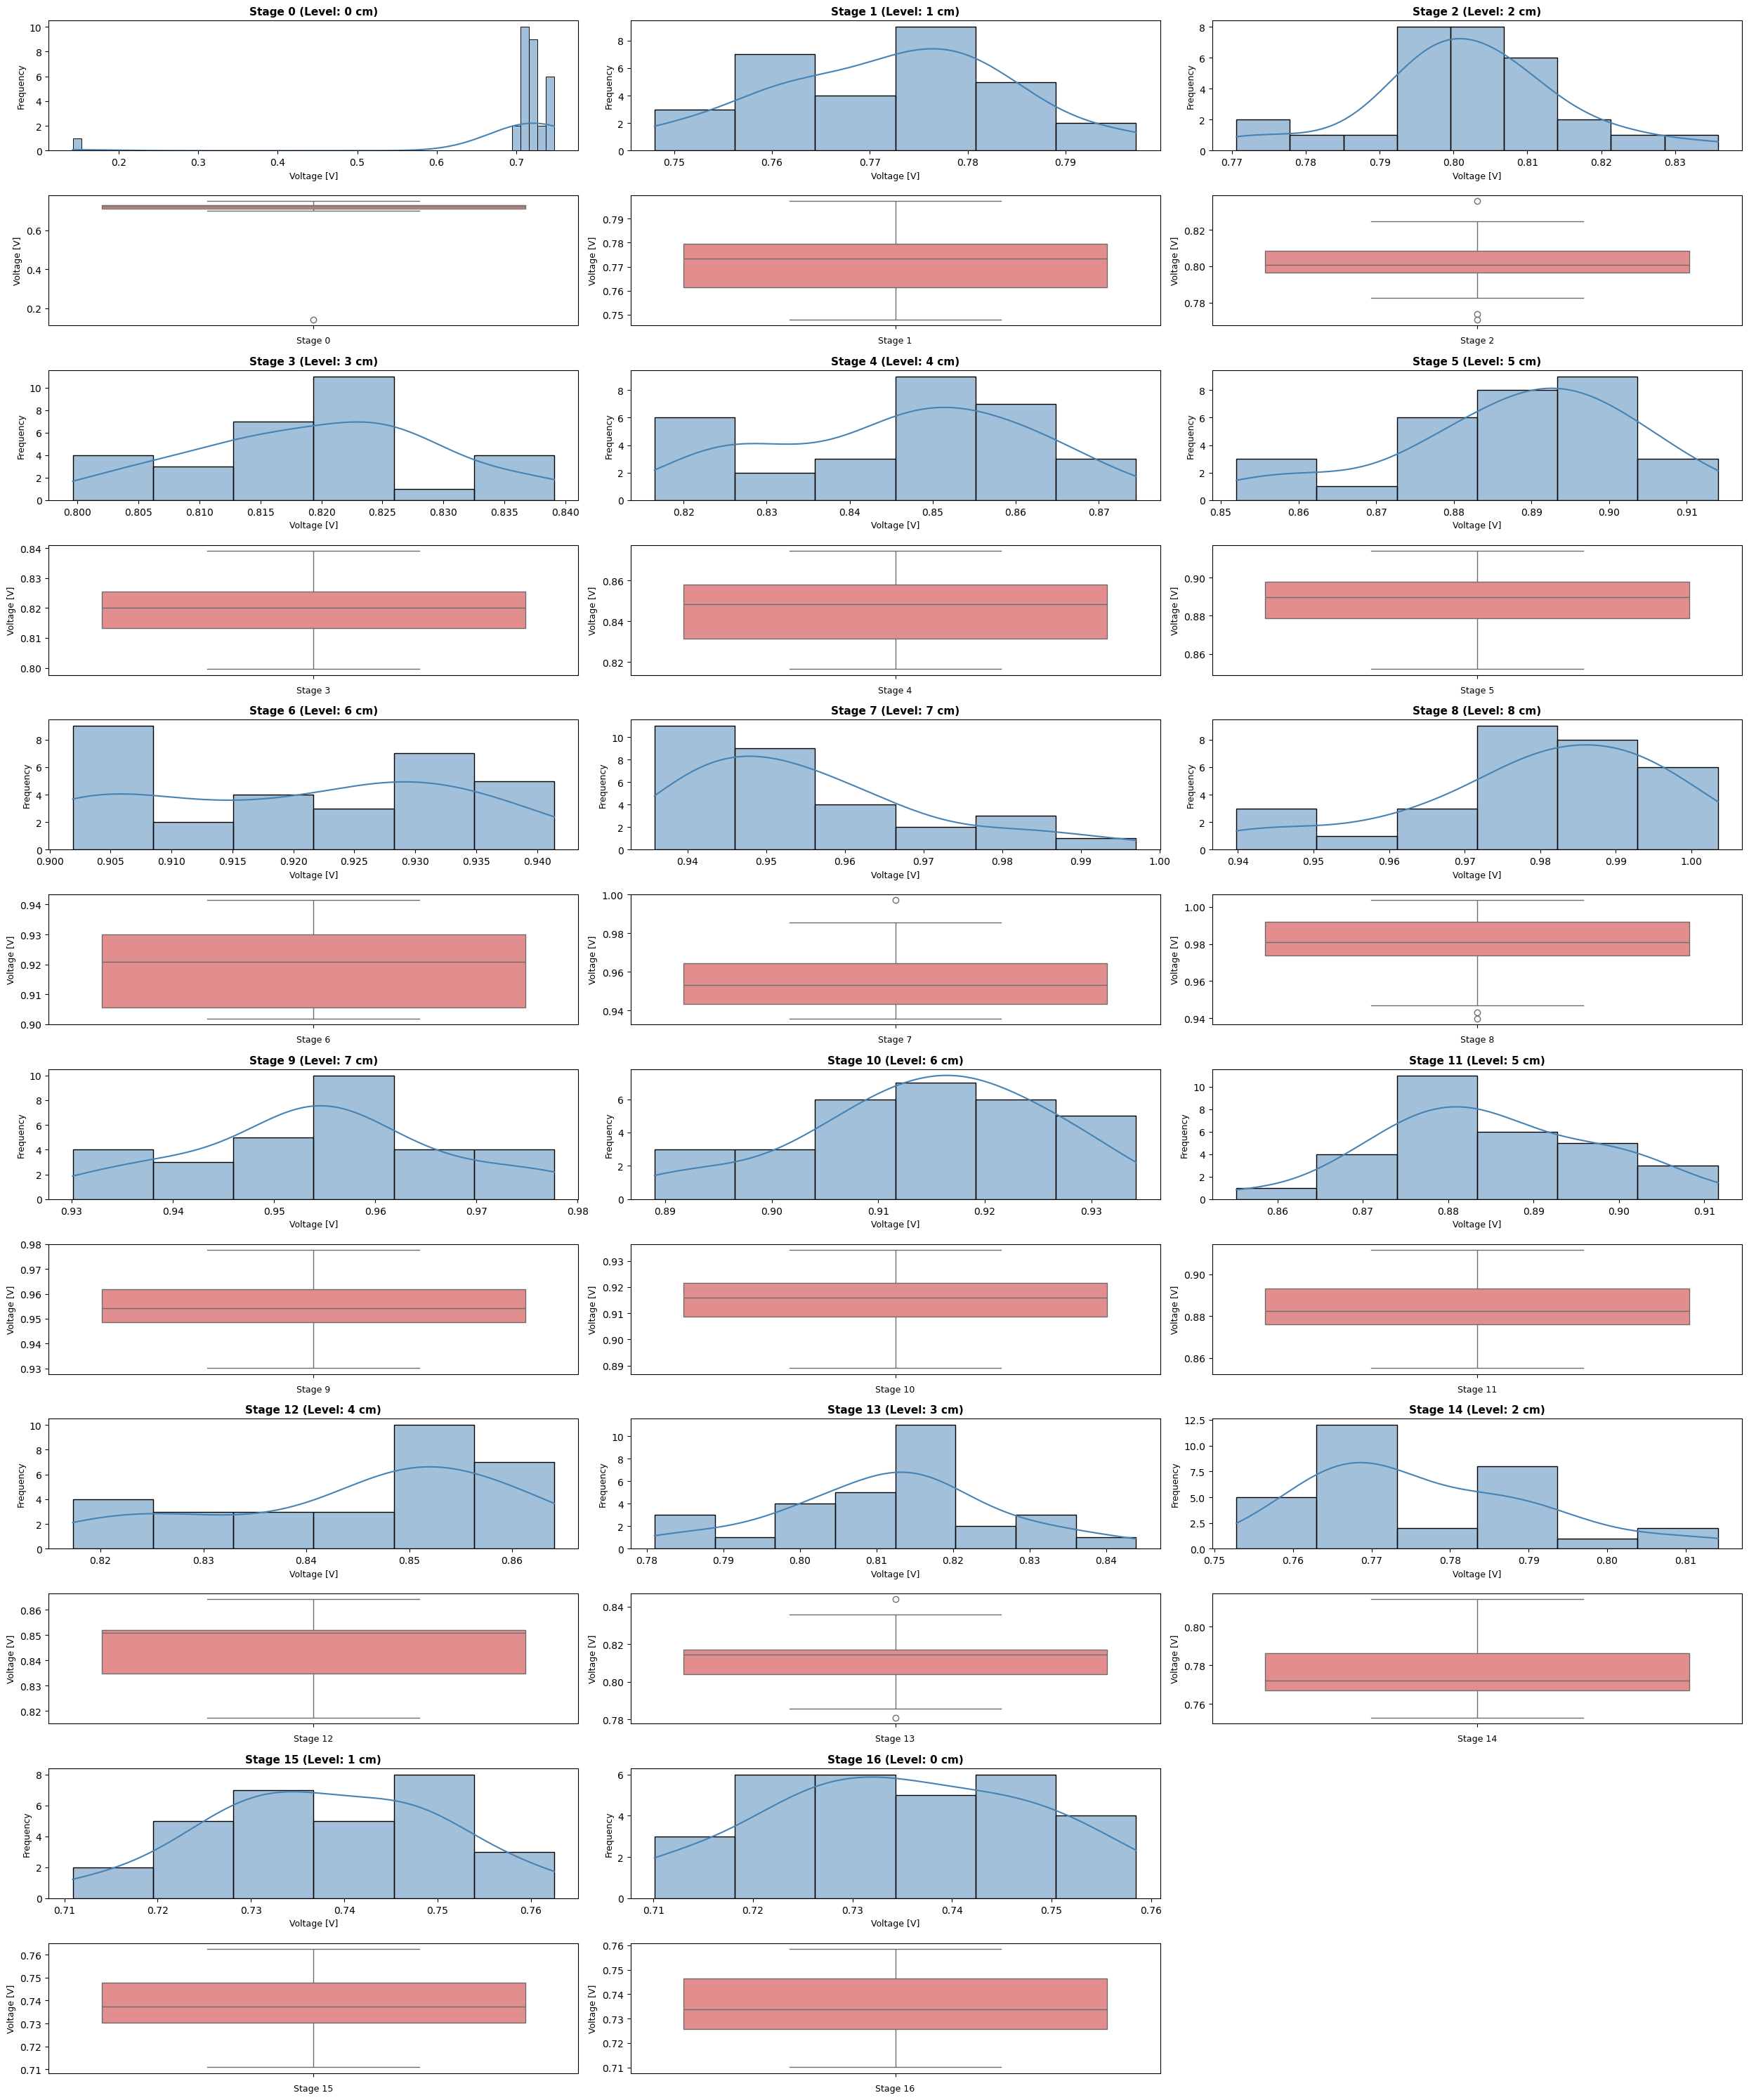

In [51]:
n_measurements = df["measurement"].nunique()
n_cols = 3
n_rows = ((n_measurements + n_cols - 1) // n_cols) * 2  # 2 rows per measurement group (hist + box)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, 30))#figsize=(5*n_cols, 4*n_rows))

# Ensure axes is 2D even if only one row
if n_rows == 1:
    axes = axes.reshape(1, -1)
if n_cols == 1:
    axes = axes.reshape(-1, 1)

for i in range(n_measurements):
    col = i % n_cols  # column position (0, 1, or 2)
    row_group = (i // n_cols) * 2  # which pair of rows (0-1, 2-3, 4-5, etc.)
    
    voltage = df[df["measurement"] == i]["voltage [V]"]
    level = df[df["measurement"] == i]["level [cm]"].iloc[0]
    
    # Histogram with KDE in the upper row of this group
    sns.histplot(voltage, kde=True, ax=axes[row_group, col], color="steelblue")
    axes[row_group, col].set_title(f"Stage {i} (Level: {level} cm)", fontsize=11, fontweight="bold")
    axes[row_group, col].set_xlabel("Voltage [V]", fontsize=9)
    axes[row_group, col].set_ylabel("Frequency", fontsize=9)
    
    # Boxplot in the lower row of this group
    sns.boxplot(y=voltage, ax=axes[row_group + 1, col], color="lightcoral")
    axes[row_group + 1, col].set_ylabel("Voltage [V]", fontsize=9)
    axes[row_group + 1, col].set_xlabel(f"Stage {i}", fontsize=9)

# Hide unused subplots
for i in range(n_measurements, n_rows * n_cols // 2):
    col = i % n_cols
    row_group = (i // n_cols) * 2
    if row_group < n_rows:
        axes[row_group, col].set_visible(False)
        axes[row_group + 1, col].set_visible(False)

plt.tight_layout()
plt.show()

With the previous analysis it is clear that a measurement error took place during the very first measurement stage. It is up to the data scientist/analyst to either keep the outlier and proceed with the analysis, or to handle it first by applying any of the many exiting techniques to handle outliers. Since the main objective of the lab is to characterize the built sensor, we will keep the original measures.

In [8]:
aggregated_values_df = df.groupby(by="measurement").agg(func="mean",)[["level [cm]", "voltage [V]"]]
aggregated_values_df

,level [cm],voltage [V]
measurement,,
0,0.0,0.702280
1,1.0,0.772153
2,2.0,0.801867
3,3.0,0.819847
4,4.0,0.845900
5,5.0,0.887933
6,6.0,0.920103
7,7.0,0.955213
8,8.0,0.979700


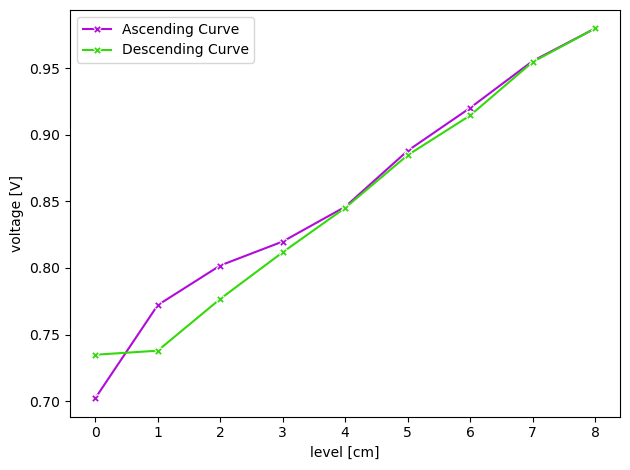

In [117]:
def print_measurement_curve():
    sns.lineplot(x=aggregated_values_df["level [cm]"].head(9), y=aggregated_values_df["voltage [V]"].head(9), marker='X', color="#B00BD9", label="Ascending Curve")
    sns.lineplot(x=aggregated_values_df["level [cm]"].tail(9), y=aggregated_values_df["voltage [V]"].tail(9), marker='X', color="#34D90B", label="Descending Curve")
print_measurement_curve()
plt.legend()
plt.tight_layout()
plt.show()

# Linear Regression

In [106]:
from sklearn.linear_model import LinearRegression

X_data = aggregated_values_df["level [cm]"].to_numpy().reshape(-1,1)
y_data = aggregated_values_df["voltage [V]"].to_numpy().reshape(-1,1)

reg = LinearRegression().fit(X=X_data, y=y_data)

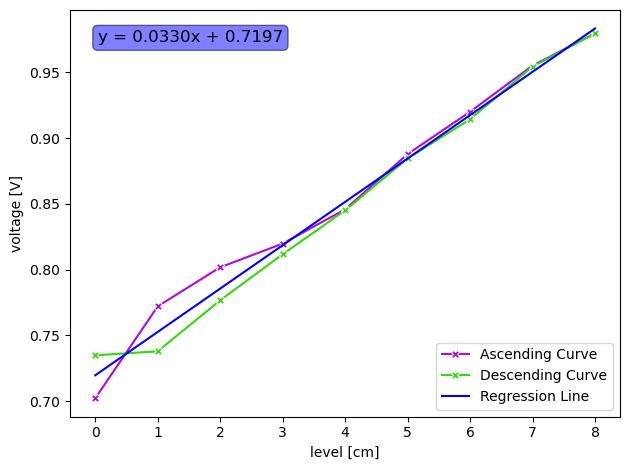

In [123]:
slope = reg.coef_[0,0]
intercept = reg.intercept_[0]
equation = f'y = {slope:.4f}x + {intercept:.4f}'

x_reg = np.linspace(start=0, stop=8, num=100)
y_reg = slope*x_reg + intercept

print_measurement_curve()
sns.lineplot(x=x_reg, y=y_reg, label="Regression Line", color="blue")
plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='blue', alpha=0.5))
plt.legend()
plt.tight_layout()
plt.show()
plt.show()